#Feed Forward Network

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split


In [3]:
dataset = MNIST(root= 'data/' , download = True ,transform= ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.52MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.56MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Lets make the training data into train and validation sets

We will keep 10000 images for validation

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [5]:
len(train_ds) , len(val_ds)

(50000, 10000)

In [6]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_ds,batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Lets use the matplot lib to show the images.


images_shape: torch.Size([128, 1, 28, 28])


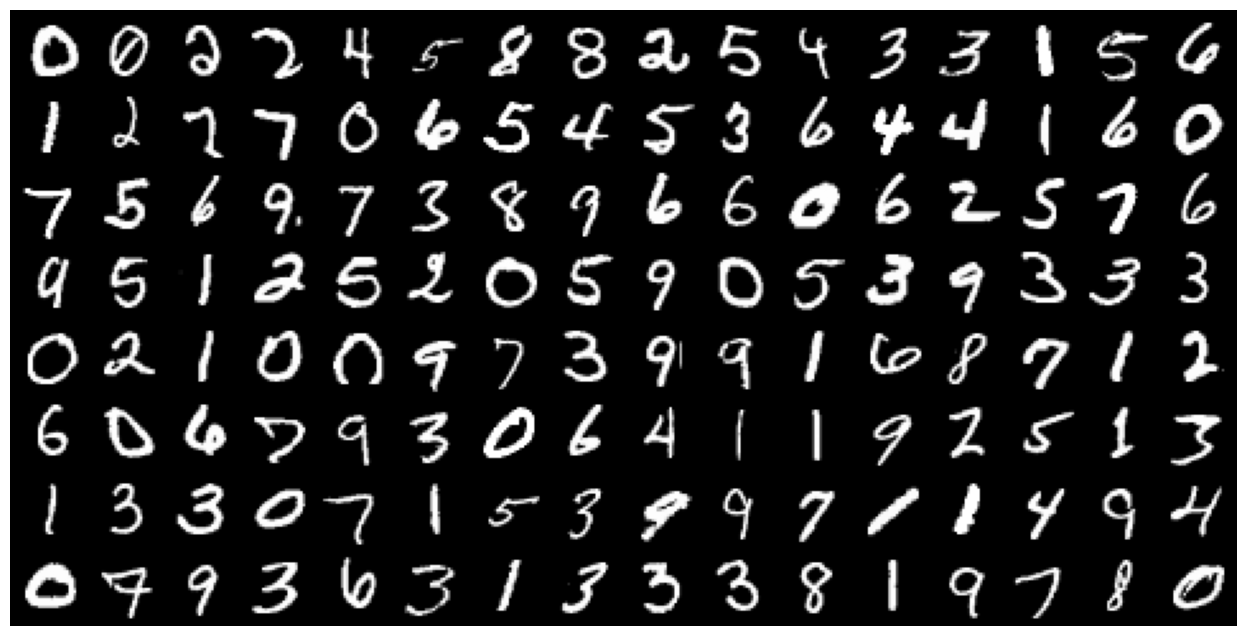

In [7]:
for images, _ in train_loader:
  print('images_shape:', images.shape)
  plt.figure(figsize = (16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow= 16).permute((1,2,0))) #make grid lets us show multiple images in one grid and nrow lets us select how many images we want to see.
  break

#permute function allow us to change the dimension of the image so that it can easily be displayed

We will create a hidden layer to capture non linear relationship between the images and their labels. Here is what this means:

instead of using a single nn.linear object to transform a batch of inputs (pixel intensitites) to output (class probabilities). We will use two nn.Linear objects. Each of these is called a layer in the network.

The first layer (also known as hidden layer) will transform the input matrix of shape **batch_size x 784** into an intermediate output matrix of shape **batch_size x hidden size**. The parameter hidden size can be configured manually (eg. 32 or 64)

We will then apply a non linear activation function to the intermediate outputs. the activation function transforms individual elements of the matrix.

The result of the activation function , which is also of size  batch_size x hidden_size is passed into the second layer (also known as the output layer).
The second layer transforms it into matrix of size batch_size x 10. We can use this output to compute the loss and adjust weights using gradient descent.

Lets create a btach of input of tensors. We will have to flatten the images into vectors of size 784, so they can be passed into an nn.Linear object.



In [8]:
for images, Labels in train_loader:
    print('images_shape:', images.shape)
    inputs = images.reshape(-1,784)
    print('inputs.shape:' , inputs.shape)
    break

images_shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Lets create our first nn.Linear object (hidden layer)

In [9]:
input_size = inputs.shape[-1]

hidden_size = 32 #we have manually set the hidden size to 32

In [10]:
layer1 = nn.Linear(input_size, hidden_size)

We will not compute intermediate outputs for the batch of images by passing inputs through layer1

In [11]:
layer1_outputs = layer1(inputs)

In [12]:
inputs.shape

torch.Size([128, 784])

In [13]:
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The input shape has been changed

Basically nn.linear is matrix multiplication and addition of vector we can use manual multipication and addition of bias and compare the answer with allclose function

In [14]:
torch.allclose(layer1_outputs, inputs @ layer1.weight.t()+layer1.bias)

True

It shows layer1_outputs and inputs have the linear relationship.

We can change this into non-linear relationship by using the rectified linear unit (ReLU). it has the formula relu(x) = max(0,x). in simple terms it replaces negative values with 0 and positive values remain the same.

We can use f.relu to apply this function

In [15]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs)', torch.min(relu_outputs).item())


min(layer1_outputs): -0.6503307223320007
min(relu_outputs) 0.0


Lets create an output layer to convert vectors of length 32 in relu_outputs into vectors of length 10 as the output for our model is 10 (Labels)

In [16]:
 output_size = 10

 layer2 = nn.Linear(hidden_size, output_size)

In [17]:
layer2_outputs = layer2(relu_outputs)
print('layer2_outputs:' , layer2_outputs.shape)

layer2_outputs: torch.Size([128, 10])


In [18]:
inputs.shape

torch.Size([128, 784])

it shows that 784 inputs will be use to show 10 outputs

Layer2 has output 10. We can now use this output to compute the loss using F.cross_entropy and adjust the weights of layer1 and layer2 using gradient descent.

In [19]:
F.cross_entropy(layer2_outputs, Labels)

tensor(2.2979, grad_fn=<NllLossBackward0>)

Our model has transformed inputs into layers2_outputs by applying a linear transformation (using layer1) followed by a non-linear activation (using f.relu) followed by another linear transformation (using layer2).

Lets varify this whole process by re-computing the output using basic matrix operations.

In [20]:
#Expanded version of layer2 (F.relu(layer1(inputs)))

outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @layer2.weight.t() + layer2.bias

In [21]:
outputs.shape

torch.Size([128, 10])

In [22]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [23]:
torch.cuda.is_available()

True

# Model

In [24]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))


In [25]:
class MnistModel(nn.Module):
  '''Feedforward neural network with 1 hidden layer'''

  def __init__(self, in_size, hidden_size, output_size):
    super().__init__()
    #hidden layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    #output layer
    self.linear2 = nn.Linear(hidden_size, output_size)



  def forward(self, xb):
    #Flatten the image sensor
    xb = xb.view(xb.size(0), -1)
    #Get intermediate outputs using hidden layer
    out = self.linear1(xb)
    #Apply activation function
    out = F.relu(out)
    #Get prediction using output layer
    out = self.linear2(out)
    return out


  def training_step(self,batch):
    images, labels = batch
    out = self(images) #Generate predictions
    loss = F.cross_entropy(out, labels) #Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss' : loss, 'val_acc' : acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   #Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()    #Combine accuracies
    return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We will create a model that contains a hidden layer with 32 activations

In [26]:
input_size = 784
hidden_size = 32
num_classes = 10



In [27]:
model = MnistModel(input_size, hidden_size= 32, output_size=num_classes)

Lets take a look at the model parameters. We expect to see one weight and bias matrix for each of the layers

In [28]:
for t in model.parameters():
  print(t.shape)


torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Lets try to generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model

In [29]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break

print('output.shape :' , outputs.shape)
print('sample outputs : ' , outputs[:2].data)

Loss: 2.3448870182037354
output.shape : torch.Size([128, 10])
sample outputs :  tensor([[ 1.7151e-01, -1.2821e-04,  1.1636e-01, -7.2482e-03, -6.7095e-02,
          1.9781e-02, -1.4676e-01, -3.2205e-02, -7.4181e-02,  2.5695e-01],
        [ 2.5043e-01,  1.0714e-02,  1.2081e-01, -5.6592e-03, -1.4973e-01,
          1.0270e-01, -1.0629e-01, -7.1656e-02, -7.7861e-02,  1.1685e-01]])


#Using a GPU

In [30]:
torch.cuda.is_available()

True

Lets define a helper function to ensure that our code uses the GPU and if it is not available then it can use CPU by default.

In [31]:
def get_default_device():
  '''Pick GPU if available, else CPU'''
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [32]:
device = get_default_device()

In [33]:
device

device(type='cuda')

Now let's define a function that can move data and model to a choosen device.

In [34]:
def to_device(data, device):
  '''Move tensors to choosen device'''
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data ]
  return data.to(device, non_blocking = True)

In [35]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cuda:0


Finally we define a dataloader class to wrap our existing data loaders and move batches of data to the selected device.

In [36]:
class DeviceDataLoader():
  '''Wrap a dataloader to move data to a choosen device'''
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to device'''
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.dl)

The yield keyword in python is used to create a generator function that can be used within a for loop as illustrated below:


In [38]:
def somenumbers():
  yield 10
  yield 20
  yield 30

for value in somenumbers():
  print(value)

10
20
30


We can now wrap our data loaders using DeviceDataLoader

In [39]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensor moved to the GPU have a device  property which includes that word cuda. lets varify this by running a batch of data from valid_load

In [40]:
for xb, yb in val_loader:
  print('xb.device :' , xb.device)
  print('yb:' , yb)
  break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


xb.device : cuda:0
yb: tensor([2, 4, 6, 9, 4, 2, 8, 0, 5, 9, 9, 8, 6, 7, 7, 4, 8, 5, 8, 3, 6, 1, 1, 9,
        7, 3, 8, 4, 9, 0, 9, 1, 9, 9, 0, 8, 7, 8, 3, 0, 2, 6, 2, 4, 8, 1, 2, 0,
        2, 5, 4, 8, 2, 2, 4, 0, 1, 3, 7, 5, 3, 2, 4, 2, 9, 4, 8, 9, 0, 4, 4, 5,
        2, 6, 4, 1, 8, 7, 7, 6, 7, 1, 8, 1, 7, 0, 7, 0, 4, 9, 6, 3, 3, 1, 4, 0,
        9, 9, 5, 0, 6, 5, 3, 7, 1, 0, 9, 8, 1, 7, 2, 3, 7, 6, 1, 0, 7, 7, 3, 7,
        4, 4, 9, 8, 1, 2, 6, 6, 0, 3, 6, 9, 9, 0, 1, 0, 8, 3, 7, 9, 6, 9, 9, 8,
        9, 6, 0, 1, 8, 7, 2, 5, 3, 0, 6, 4, 7, 1, 5, 3, 6, 6, 4, 6, 1, 6, 8, 2,
        6, 3, 3, 8, 7, 1, 5, 0, 8, 6, 5, 4, 5, 1, 0, 6, 1, 1, 5, 3, 2, 8, 2, 1,
        3, 9, 3, 7, 9, 5, 2, 7, 9, 8, 9, 4, 5, 3, 7, 5, 0, 7, 7, 5, 6, 0, 7, 5,
        1, 5, 8, 7, 5, 5, 3, 3, 0, 7, 6, 4, 0, 9, 1, 3, 6, 6, 1, 6, 8, 1, 2, 6,
        9, 7, 3, 7, 2, 6, 1, 3, 7, 8, 8, 3, 0, 5, 4, 8], device='cuda:0')


# Training the model

lets run fit and evaluate to train the model using gradient descent and evaluates its performance on the validation set.

In [41]:
def evaluate(model, val_loader):
  '''Evaluate the model performance on the validation data set.'''
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_loader,val_loader,opt_func = torch.optim.SGD):
  '''Train the model using gradient descent'''
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    #Training phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history



Lets wrap and move our model on GPU aswell.

In [42]:
#Model on GPU

model = MnistModel(input_size, hidden_size = hidden_size, output_size = num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

lets check how the model performson the validation set with the initial set of weight and biases

In [43]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[{'val_loss': 2.3121144771575928, 'val_acc': 0.08896484225988388}]

The inital accuracy is around 10%

**Let's train the model for five epochs and see the results**

**We can use a high learning rate**

In [44]:
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [0], val_loss: 0.2330, val_acc: 0.9316
Epoch [1], val_loss: 0.3272, val_acc: 0.9007
Epoch [2], val_loss: 0.1778, val_acc: 0.9458
Epoch [3], val_loss: 0.1589, val_acc: 0.9546
Epoch [4], val_loss: 0.1423, val_acc: 0.9569


**We have the accuracy of 96%**

In [45]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1328, val_acc: 0.9599
Epoch [1], val_loss: 0.1305, val_acc: 0.9590
Epoch [2], val_loss: 0.1287, val_acc: 0.9615
Epoch [3], val_loss: 0.1287, val_acc: 0.9622
Epoch [4], val_loss: 0.1322, val_acc: 0.9604


**Lets plot the loss and accuracies to study how the model improves over time**

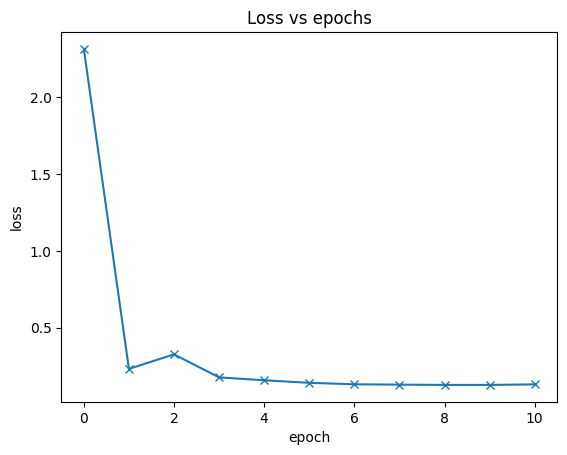

In [47]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs epochs');

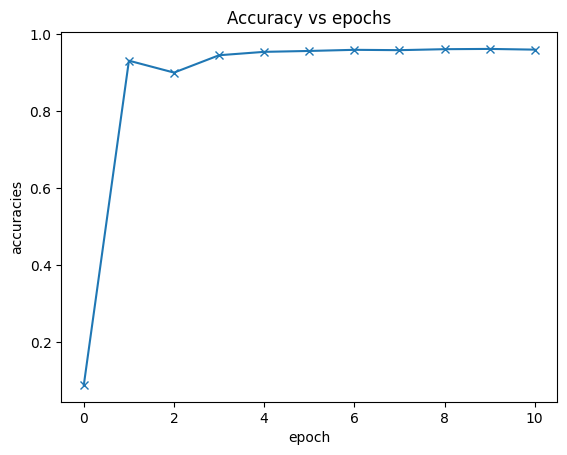

In [48]:
#Accuracies

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.title('Accuracy vs epochs');

# Test the model on testing images

In [49]:
#Define test dataset

test_dataset = MNIST(root = 'data/',
                     train = False,
                     transform = ToTensor())

Let's define a function predict_images, which returns the predicted label for a single image tensor

In [50]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim = 1)
  return preds[0].item()

Let's try out for some images.

label: 7 Predicted: 7


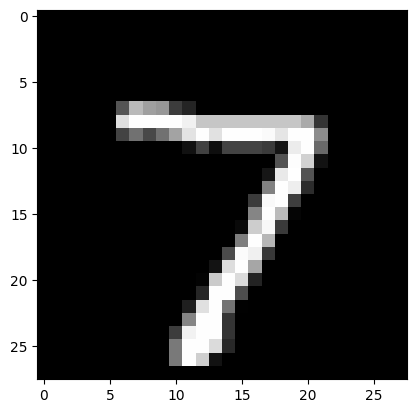

In [53]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'grey')
print('label:', label, 'Predicted:' , predict_image(img, model))

label: 4 Predicted: 4


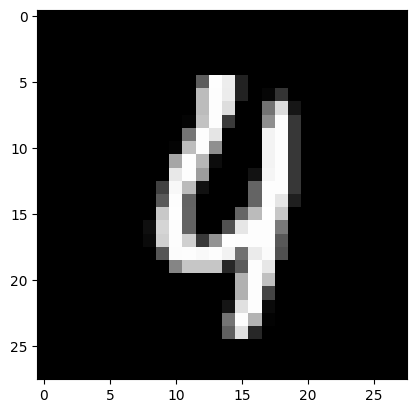

In [54]:
img, label = test_dataset[532]
plt.imshow(img[0], cmap = 'grey')
print('label:', label, 'Predicted:' , predict_image(img, model))

label: 9 Predicted: 9


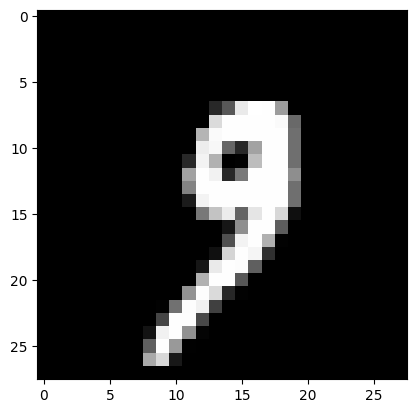

In [55]:
img, label = test_dataset[1000]
plt.imshow(img[0], cmap = 'grey')
print('label:', label, 'Predicted:' , predict_image(img, model))

As a final step, lets look at overall loss and accuracy of the model on the test set.

In [57]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size = 256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.09931831806898117, 'val_acc': 0.9712890386581421}

In [58]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')